<a href="https://colab.research.google.com/github/franksalomon/Machine-Learning-Models/blob/main/Analisis_carData_Datos_de_Chile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
install.packages(c(
  "carData",   # dataset Chile
  "dplyr",     # manipulación de datos
  "Metrics",   # RMSE, MAE
  "rpart",     # árboles de regresión/clasificación
  "rpart.plot", # gráficos bonitos de árboles
  "pROC",
  "randomForest"# bosques aleatorios
))


Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



El conjunto de datos Chile contiene información proveniente de una encuesta nacional realizada en Chile antes del plebiscito de 1988, en el cual los ciudadanos debían votar “Sí” o “No” a la continuidad del régimen militar.
El objetivo del estudio era analizar las actitudes políticas, demográficas y socioeconómicas de los encuestados.

| Variable       | Tipo / Escala       | Descripción breve                                      | Categorías o rango                                                |
| -------------- | ------------------- | ------------------------------------------------------ | ----------------------------------------------------------------- |
| **region**     | Categórica nominal  | Zona geográfica del país                               | C = Central, M = Metropolitana, N = Norte, S = Sur, SA = Santiago |
| **population** | Numérica (entera)   | Tamaño de la población del área de residencia          | 3 750 – 250 000                                                   |
| **sex**        | Categórica binaria  | Sexo del encuestado                                    | F = Femenino, M = Masculino                                       |
| **age**        | Numérica (entera)   | Edad del encuestado                                    | 18 – 70 años                                                      |
| **education**  | Categórica ordinal  | Nivel educativo alcanzado                              | P = Primaria, S = Secundaria, PS = Post-secundaria                |
| **income**     | Numérica (continua) | Ingreso familiar mensual (pesos chilenos de la época)  | 2 500 – 200 000                                                   |
| **statusquo**  | Numérica (continua) | Actitud hacia el régimen existente (escala ideológica) | -1.8 – +2.0 (valores negativos = oposición, positivos = apoyo)    |
| **vote**       | Categórica nominal  | Intención de voto en el plebiscito de 1988             | Y = Sí, N = No, U = Indeciso, A = Abstención                      |


In [ ]:
# =========================
# 1) Paquetes y datos
# =========================
library(carData)
library(dplyr)

data("Chile")

# =========================
# 2) Inspección rápida (salidas rotuladas)
# =========================
cat("\n=== Vista inicial (6 filas) ===\n")
print(head(Chile))

cat("\n=== Resumen estadístico ===\n")
print(summary(Chile))

cat("\n=== Dimensiones del dataset ===\n")
cat("Filas:", nrow(Chile), " | Columnas:", ncol(Chile), "\n")

# =========================
# 3) Porcentaje de NA por variable (tabla ordenada)
# =========================
na_percent <- colMeans(is.na(Chile)) * 100
na_summary <- data.frame(
  Variable   = names(na_percent),
  pct_na_num = round(as.numeric(na_percent), 2)
) %>%
  arrange(desc(pct_na_num)) %>%
  mutate(`Porcentaje de NA` = paste0(pct_na_num, "%")) %>%
  select(Variable, `Porcentaje de NA`)

cat("\n=== Porcentaje de NA por variable ===\n")
print(na_summary, row.names = FALSE)

# =========================
# 4) Pérdida por eliminación lista (listwise deletion)
# =========================
n_total  <- nrow(Chile)
n_sin_na <- nrow(na.omit(Chile))
porcentaje_perdido <- round((n_total - n_sin_na) / n_total * 100, 2)

cat("\n=== Pérdida por listwise deletion ===\n")
cat("Total de filas      :", n_total, "\n")
cat("Filas sin NA        :", n_sin_na, "\n")
cat("Porcentaje perdido  :", porcentaje_perdido, "%\n")

# =========================
# 5) Ordenar factor education
# =========================
Chile$education <- factor(Chile$education, levels = c("P", "S", "PS"), ordered = TRUE)
cat("\n=== Niveles de 'education' (ordenados) ===\n")
print(levels(Chile$education))

# = ========================
# 6) Verificación de filas duplicadas
# =========================
# Se revisó si existían filas idénticas en el dataset.
# Aunque se detectaron algunas coincidencias, esto es normal en encuestas,
# ya que distintas personas pueden responder exactamente igual.

cat("Número de filas duplicadas (coincidencias completas):", sum(duplicated(Chile)), "\n")



=== Vista inicial (6 filas) ===
  region population sex age education income statusquo vote
1      N     175000   M  65         P  35000   1.00820    Y
2      N     175000   M  29        PS   7500  -1.29617    N
3      N     175000   F  38         P  15000   1.23072    Y
4      N     175000   F  49         P  35000  -1.03163    N
5      N     175000   F  23         S  35000  -1.10496    N
6      N     175000   F  28         P   7500  -1.04685    N

=== Resumen estadístico ===
 region     population     sex           age        education  
 C :600   Min.   :  3750   F:1379   Min.   :18.00   P   :1107  
 M :100   1st Qu.: 25000   M:1321   1st Qu.:26.00   PS  : 462  
 N :322   Median :175000            Median :36.00   S   :1120  
 S :718   Mean   :152222            Mean   :38.55   NA's:  11  
 SA:960   3rd Qu.:250000            3rd Qu.:49.00              
          Max.   :250000            Max.   :70.00              
                                    NA's   :1                  
     i

El grupo con educación primaria (P) presenta una mediana y un rango intercuartílico ligeramente más altos que los de S y PS, por ello se puede decir que el grupo con educación primaria (P) muestra una mediana ligeramente positiva, lo que indica que más del 50% de sus respuestas en Status Quo son mayores que cero. En cambio, los grupos con educación secundaria (S) y post-secundaria (PS) presentan medianas negativas, lo que implica que en estos grupos menos del 50% de los individuos tienen valores positivos de Status Quo.

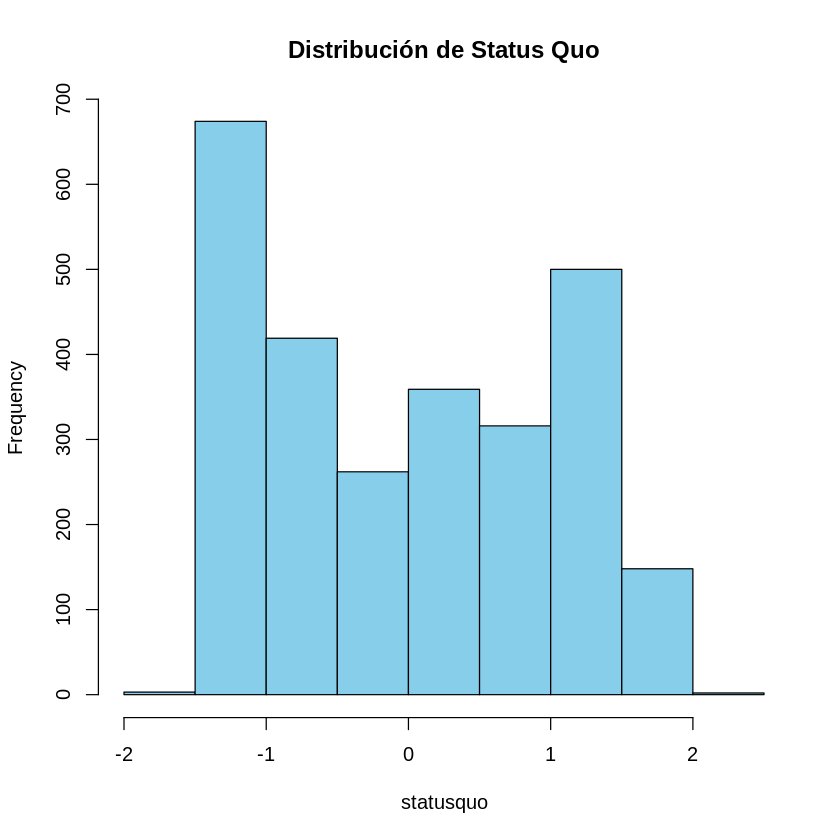

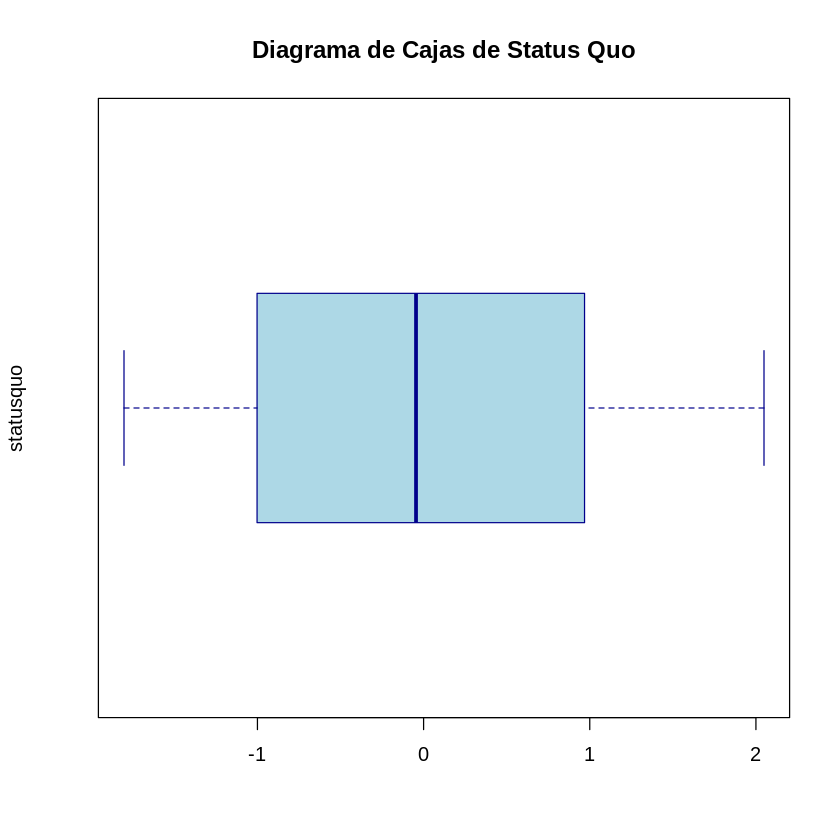

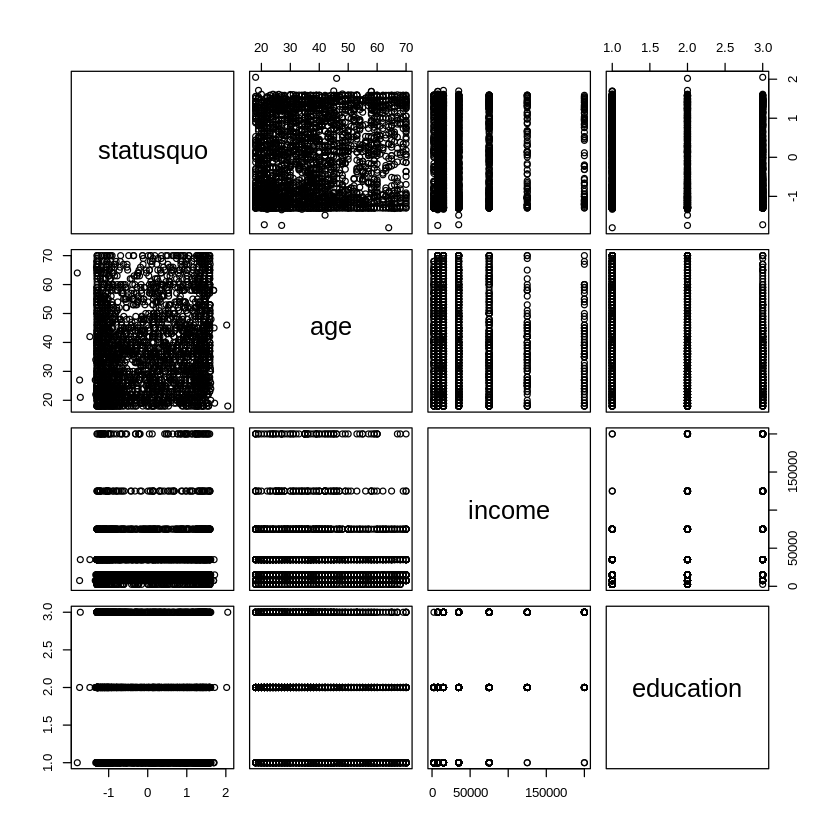

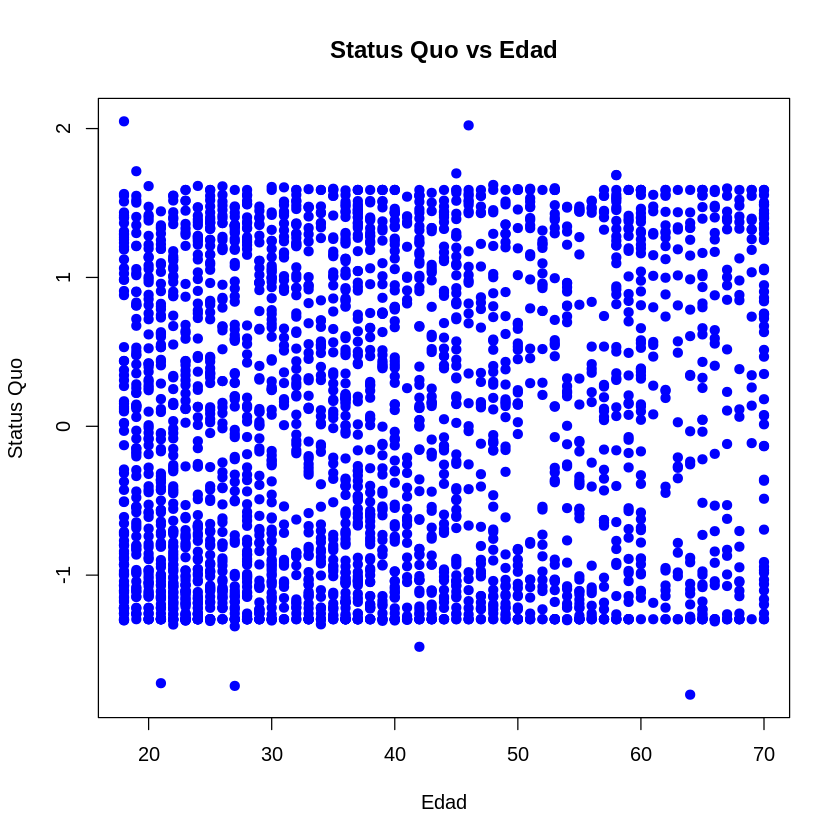

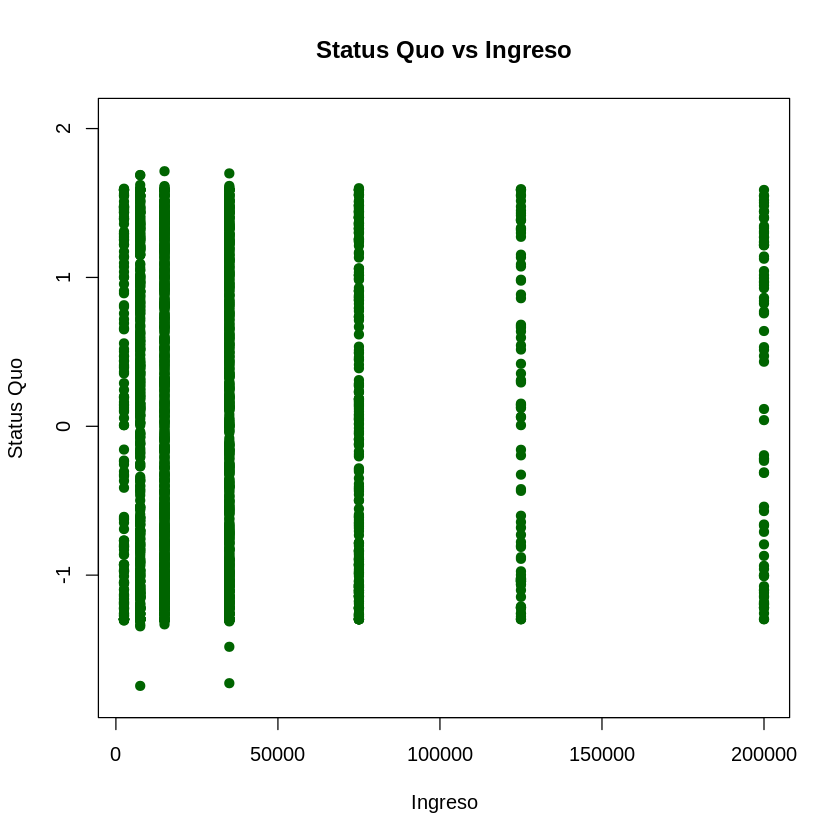

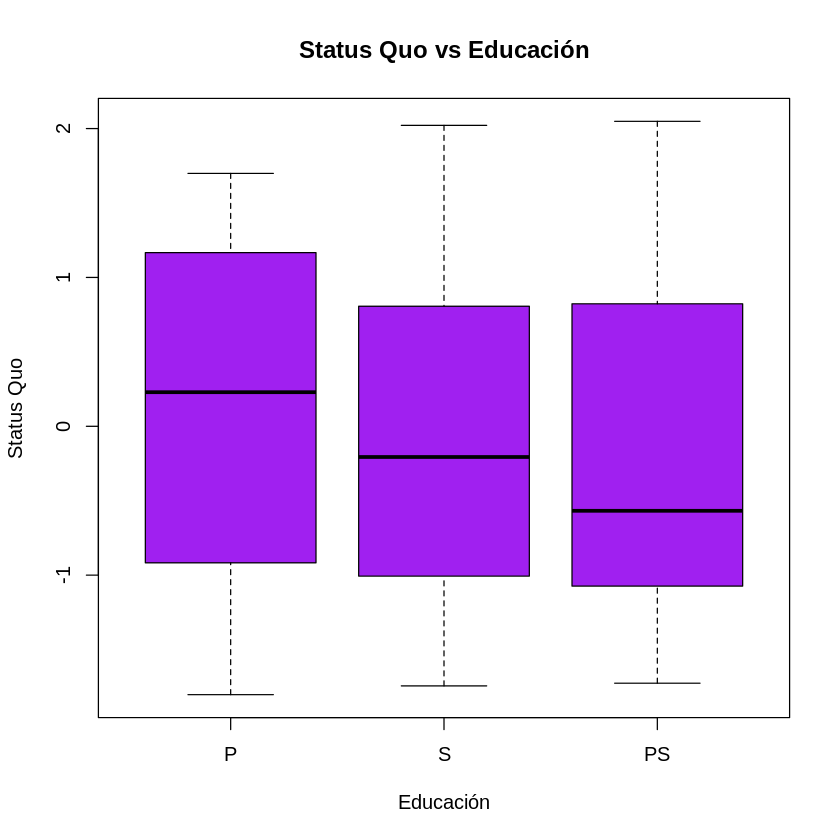

In [ ]:
hist(Chile$statusquo, main = "Distribución de Status Quo",
     xlab = "statusquo", col = "skyblue")

boxplot(Chile$statusquo, main = "Diagrama de Cajas de Status Quo", ylab = "statusquo", col = "lightblue",
        border = "darkblue", horizontal = TRUE)


pairs(~ statusquo + age + income + education, data = Chile)
# Dispersión: statusquo vs age
plot(Chile$age, Chile$statusquo,
     main = "Status Quo vs Edad",
     xlab = "Edad",
     ylab = "Status Quo",
     col = "blue", pch = 19)

# Dispersión: statusquo vs income
plot(Chile$income, Chile$statusquo,
     main = "Status Quo vs Ingreso",
     xlab = "Ingreso",
     ylab = "Status Quo",
     col = "darkgreen", pch = 19)

# Dispersión: statusquo vs education
plot(Chile$education, Chile$statusquo,
     main = "Status Quo vs Educación",
     xlab = "Educación",
     ylab = "Status Quo",
     col = "purple", pch = 19)



Los coeficientes indican que ser hombre (sexM) reduce significativamente el status quo, ya que su efecto es negativo, dado que el coeficiente negativo de sexM indica que los hombres presentan un nivel de status quo significativamente menor que las mujeres, que son la categoría de referencia en el modelo. La edad tiene un efecto positivo y significativo, mostrando que las personas mayores tienden ligeramente a apoyar más el status quo. En cuanto a la educación, el componente lineal (education.L) es negativo y altamente significativo, lo que sugiere que, a mayor nivel educativo, disminuye el apoyo al status quo, mientras que el componente cuadrático (education.Q) no es significativo.

Por último, el ingreso presenta un coeficiente positivo y significativo, lo que implica que las personas con mayores ingresos tienden a mostrar mayor apoyo al status quo. El intercepto negativo indica que, para un individuo en las categorías base (mujer, nivel educativo de referencia, ingreso y edad cero), el valor esperado del status quo es levemente negativo.


In [ ]:
model_lm <- lm(statusquo ~ sex + age + education + income, data = Chile,   na.action = na.omit)
cat("\n=== Coeficientes del modelo lineal ===\n")
print(coef(model_lm))

summary(model_lm)



=== Coeficientes del modelo lineal ===
  (Intercept)          sexM           age   education.L   education.Q 
-2.721905e-01 -1.210410e-01  4.492399e-03 -3.161921e-01  2.286891e-02 
       income 
 2.892994e-06 



Call:
lm(formula = statusquo ~ sex + age + education + income, data = Chile, 
    na.action = na.omit)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.67262 -0.91146 -0.08131  0.93493  2.07015 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.722e-01  6.171e-02  -4.411 1.07e-05 ***
sexM        -1.210e-01  3.885e-02  -3.116  0.00186 ** 
age          4.492e-03  1.412e-03   3.181  0.00149 ** 
education.L -3.162e-01  4.582e-02  -6.901 6.46e-12 ***
education.Q  2.287e-02  3.396e-02   0.673  0.50077    
income       2.893e-06  5.493e-07   5.266 1.51e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9819 on 2575 degrees of freedom
  (119 observations deleted due to missingness)
Multiple R-squared:  0.03956,	Adjusted R-squared:  0.03769 
F-statistic: 21.21 on 5 and 2575 DF,  p-value: < 2.2e-16


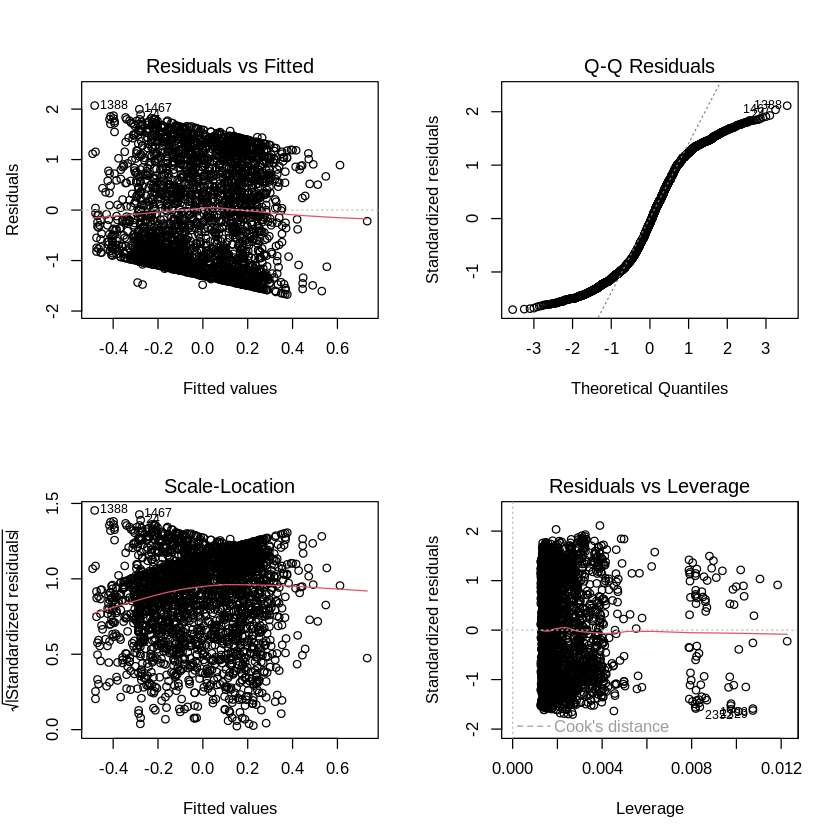

In [ ]:
par(mfrow = c(2,2))
plot(model_lm)
par(mfrow = c(1,1))


El análisis del gráfico de complejidad (CP plot) y de la tabla de CP muestra que el menor error de validación (xerror = 0.98336) ocurre en CP = 0.0074557, por lo que este valor es el óptimo para podar el árbol. Bajo este criterio, el árbol resultante realiza solo una partición, generando únicamente dos hojas. Esto sucede porque añadir divisiones adicionales no reduce el error predictivo; por el contrario, lo incrementa, indicando que el modelo no se beneficia de mayor complejidad. Por ello, el árbol óptimo es muy simple: una única división que separa los datos en dos grupos según la variable educación.

El gráfico del árbol podado muestra que la única división se realiza sobre si la persona tiene educación secundaria o postsecundaria (educación = S o PS). Para quienes pertenecen a estos niveles educativos (rama “yes”), el valor medio de status quo es –0.11, indicando una tendencia ligeramente negativa hacia mantener la situación actual. Este grupo corresponde al 59% de la muestra. En contraste, quienes tienen educación primaria (rama “no”) presentan un promedio positivo de status quo (0.16), lo que refleja mayor inclinación por mantener el estado actual, y representan el 41% de la muestra. En conjunto, el árbol revela que la educación es la variable más relevante para dividir la población en términos de su apoyo o rechazo al status quo.


Regression tree:
rpart(formula = statusquo ~ sex + age + education + income, data = Chile, 
    method = "anova", cp = 0)

Variables actually used in tree construction:
[1] age       education income    sex      

Root node error: 2683/2683 = 1

n=2683 (17 observations deleted due to missingness)

            CP nsplit rel error  xerror     xstd
1   1.7691e-02      0   1.00000 1.00065 0.014290
2   7.4557e-03      1   0.98231 0.98433 0.014851
3   5.3122e-03      2   0.97485 0.98591 0.015013
4   3.6440e-03      3   0.96954 0.98627 0.015120
5   3.3223e-03      4   0.96590 0.98864 0.015482
6   2.6964e-03      5   0.96257 0.98977 0.015606
7   2.4404e-03      8   0.95449 0.98799 0.015741
8   2.1028e-03      9   0.95205 0.98971 0.015893
9   1.8907e-03     10   0.94994 0.99739 0.016374
10  1.7601e-03     11   0.94805 1.00083 0.016627
11  1.7187e-03     13   0.94453 1.00147 0.016773
12  1.5887e-03     14   0.94281 0.99957 0.016805
13  1.5415e-03     17   0.93805 0.99894 0.016878
14  1.4758e-03

[1] 0.00745572

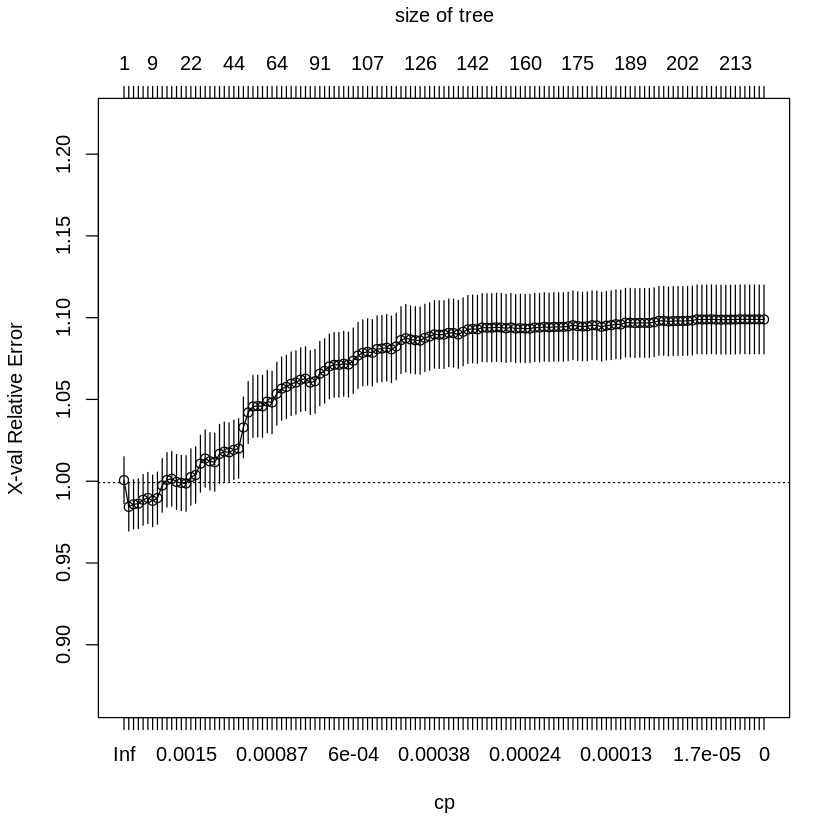

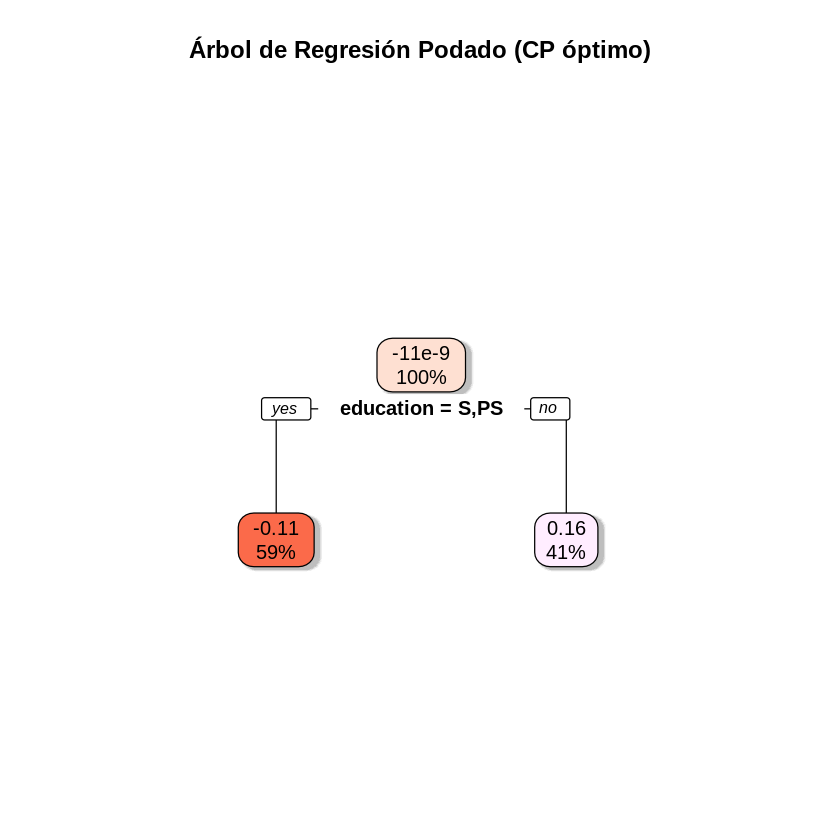

In [ ]:

library(rpart)
library(rpart.plot)

# Árbol de regresión
tree_model <- rpart(
  statusquo ~ sex + age + education + income,
  data = Chile,
  method = "anova",
  cp = 0    # dejar crecer
)


# Mostrar resultados del árbol
printcp(tree_model)
plotcp(tree_model)

best_cp <- tree_model$cptable[ which.min(tree_model$cptable[ , "xerror" ]), "CP" ]
best_cp

pruned_tree <- prune(tree_model, cp = best_cp)

# Graficar el árbol de forma elegante
rpart.plot(
  pruned_tree,
  type = 2,
  fallen.leaves = TRUE,
  shadow.col = "gray",
  box.palette = "RdPu",
  main = "Árbol de Regresión Podado (CP óptimo)"
)


###**Comparación del rendimiento entre regresión lineal y árbol de regresión para predecir statusquo**
En esta parte del análisis comparé un modelo de regresión lineal y un árbol de regresión utilizando statusquo como variable respuesta. Para evaluar su desempeño utilicé las métricas RMSE, MAE y R². El modelo lineal obtuvo un RMSE de 0.98, un MAE de 0.87 y un R² de 0.039, lo que significa que explica alrededor del 4% de la variabilidad de statusquo y comete errores relativamente altos. El árbol podado mostró valores muy similares: RMSE de 0.985, MAE de 0.877 y R² de 0.030, lo que indica que explica apenas cerca del 3% de la variación.

En general, aunque el árbol de regresión puede capturar patrones no lineales, su capacidad predictiva para statusquo es muy limitada y no supera a la regresión lineal. Ambos modelos muestran un ajuste débil, por lo que ninguno resulta especialmente eficaz para predecir esta variable con las características disponibles.

In [ ]:
# =========================
# 7) Métricas: RMSE, MAE, R²
# =========================
library(Metrics)

# Datos completos para las variables usadas en los modelos
datos_modelo <- Chile %>%
  dplyr::select(statusquo, sex, age, education, income) %>%
  na.omit()

# Predicciones alineadas con datos_modelo
pred_lm   <- predict(model_lm,   newdata = datos_modelo)
pred_tree <- predict(pruned_tree, newdata = datos_modelo)

# RMSE
rmse_lm   <- rmse(datos_modelo$statusquo, pred_lm)
rmse_tree <- rmse(datos_modelo$statusquo, pred_tree)

# MAE
mae_lm    <- mae(datos_modelo$statusquo, pred_lm)
mae_tree  <- mae(datos_modelo$statusquo, pred_tree)

# R² "a mano"
r2_lm <- 1 - sum((datos_modelo$statusquo - pred_lm)^2) /
             sum((datos_modelo$statusquo - mean(datos_modelo$statusquo))^2)

r2_tree <- 1 - sum((datos_modelo$statusquo - pred_tree)^2) /
               sum((datos_modelo$statusquo - mean(datos_modelo$statusquo))^2)

cat("\n=== Métricas de ajuste ===\n")
cat("Modelo lineal   - RMSE:", rmse_lm,   " | MAE:", mae_lm,   " | R²:", r2_lm,   "\n")
cat("Árbol podado    - RMSE:", rmse_tree, " | MAE:", mae_tree, " | R²:", r2_tree, "\n")




=== Métricas de ajuste ===
Modelo lineal   - RMSE: 0.9807669  | MAE: 0.87036  | R²: 0.03955989 
Árbol podado    - RMSE: 0.9910878  | MAE: 0.8851901  | R²: 0.01923948 


###**Explicación del cambio de la variable respuesta para aplicar regresion logistica,  clasification tree y compararlos**
Para comparar la regresión logística y el árbol de clasificación, primero trabajé solo con los votos SÍ (Y) y NO (N). Para eso filtré el conjunto de datos y eliminé las observaciones donde la variable vote era A o U, quedándome únicamente con Y y N. Esto permitió usar una variable respuesta binaria y aplicar ambos modelos de forma consistente. Luego ajusté la regresión logística con las variables sexo, edad, educación e ingresos, mientras que el árbol terminó usando principalmente la variable educación para separar a los votantes.
Las matrices de confusión nos permite ver cuántos casos clasificó bien cada modelo. En la regresión logística, de los votantes NO, 558 fueron clasificados correctamente y 309 fueron confundidos como SÍ. En cuanto a los votantes SÍ, 483 fueron bien clasificados y 354 fueron clasificados erróneamente como NO. En el árbol, los resultados fueron distintos: clasificó mejor a los NO (605 correctos y 262 incorrectos), pero peor a los SÍ (solo 410 correctos frente a 427 mal clasificados). Esto muestra que el logit es más equilibrado, mientras que el árbol tiende a identificar mejor a los NO, pero pierde precisión con los SÍ.
Para evaluar la calidad general de cada modelo utilicé las curvas ROC y el AUC. La curva ROC es útil porque no depende del punto de corte 0.5, sino que analiza todos los posibles umbrales y muestra la relación entre la sensibilidad y la especificidad. Al observar el gráfico, se nota que la curva de la regresión logística está más arriba y más alejada de la línea diagonal que la del árbol, lo que indica que discrimina mejor entre los votos SÍ y NO. El AUC resume esta información en un solo número: la regresión logística obtuvo un valor aproximado de 0.65, mientras que el árbol alcanzó cerca de 0.59. Como un AUC de 0.5 significa que el modelo no tiene capacidad de clasificación, el gráfico y estos valores confirman que ambos modelos tienen una capacidad moderada, pero la regresión logística es claramente superior al árbol en todo el rango de puntos de corte.
En conjunto, estos resultados muestran que la regresión logística es el modelo más efectivo para predecir si una persona votará SÍ o NO, ya que clasifica mejor a los votantes SÍ y tiene un AUC más alto. El árbol es más sencillo de interpretar, pero al depender casi solo de la educación, pierde capacidad predictiva. Por eso, para este problema en particular, la regresión logística termina siendo la opción más adecuada.


  N   Y 
889 868 


Call:
glm(formula = vote ~ sex + age + education + income, family = binomial, 
    data = Chile_yn, na.action = na.omit)

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -4.820e-01  1.555e-01  -3.099 0.001941 ** 
sexM        -5.415e-01  1.009e-01  -5.365 8.10e-08 ***
age          1.203e-02  3.594e-03   3.347 0.000817 ***
education.L -7.954e-01  1.171e-01  -6.791 1.12e-11 ***
education.Q  6.079e-02  8.701e-02   0.699 0.484764    
income       4.481e-06  1.342e-06   3.339 0.000840 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2361.7  on 1703  degrees of freedom
Residual deviance: 2239.0  on 1698  degrees of freedom
  (53 observations deleted due to missingness)
AIC: 2251

Number of Fisher Scoring iterations: 4



=== Matriz de confusión - Logit (Y vs N) ===
    Pred_Logit
Real   N   Y
   N 558 309
   Y 354 483

=== Matriz de confusión - Árbol (Y vs N) ===
    Pred_Tree
Real   N   Y
   N 605 262
   Y 427 410


Setting levels: control = N, case = Y

Setting direction: controls < cases

Setting levels: control = N, case = Y

Setting direction: controls < cases




AUC Logit: 0.6521299 
AUC Árbol: 0.5938266 


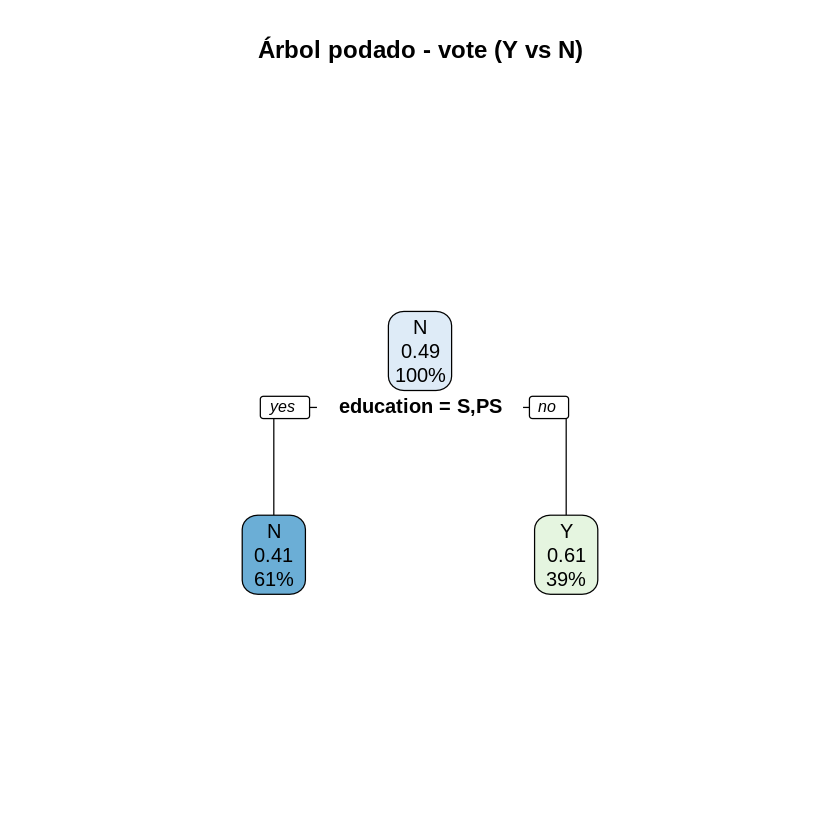

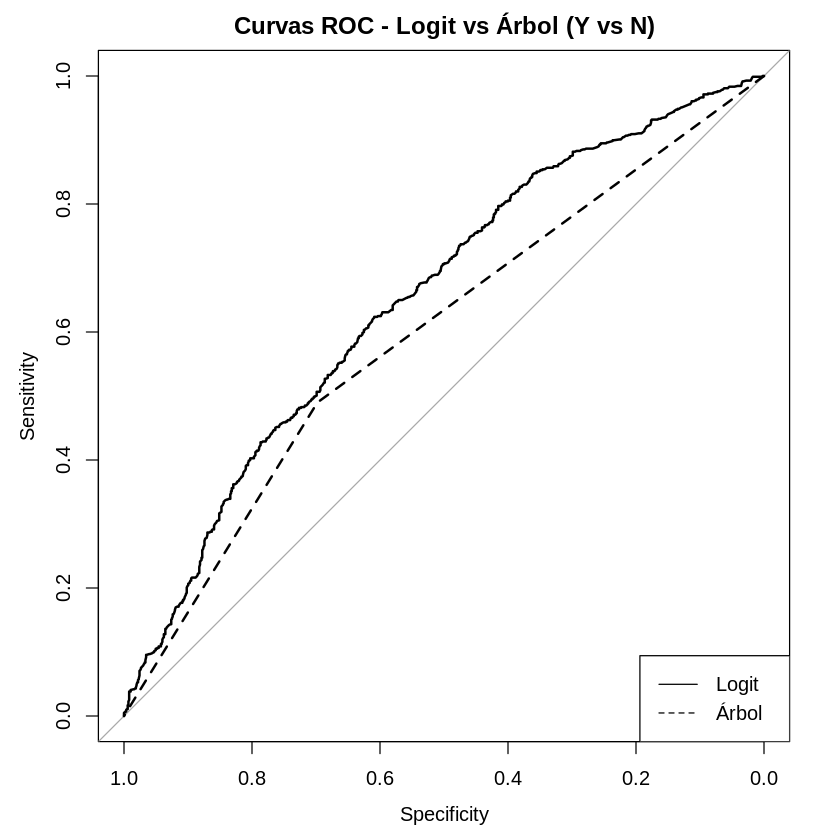

In [ ]:
## =================================================
## 1. Cargar librerías
## =================================================
library(rpart)
library(rpart.plot)
library(pROC)
library(dplyr)

## =================================================
## 2. Filtrar datos: solo Y (sí) y N (no)
##    Eliminamos A y U de la variable respuesta
## =================================================

# Nos quedamos con filas donde vote es "Y" o "N"
Chile_yn <- Chile %>%
  filter(vote %in% c("Y", "N"))

# Quitamos niveles sobrantes y fijamos el orden: N = no, Y = sí
Chile_yn$vote <- droplevels(Chile_yn$vote)
Chile_yn$vote <- factor(Chile_yn$vote, levels = c("N", "Y"))

## (Opcional) Verificar distribución
table(Chile_yn$vote)

## =================================================
## 3. Modelo Logístico (binario: N vs Y)
## =================================================

model_logit <- glm(
  vote ~ sex + age + education + income,
  data   = Chile_yn,
  family = binomial,
  na.action = na.omit
)

summary(model_logit)

## =================================================
## 4. Árbol de Clasificación (grande + poda)
## =================================================

tree_big <- rpart(
  vote ~ sex + age + education + income,
  data   = Chile_yn,
  method = "class",
  cp     = 0,
  na.action = na.omit
)

# Elegir mejor cp según error de validación cruzada
best_cp <- tree_big$cptable[which.min(tree_big$cptable[, "xerror"]), "CP"]

# Podar el árbol
tree_pruned <- prune(tree_big, cp = best_cp)

## (Opcional) Graficar el árbol podado
rpart.plot(tree_pruned, main = "Árbol podado - vote (Y vs N)")

## =================================================
## 5. Predicciones de probabilidad para ambos modelos
## =================================================

## ---- Logit: probabilidad de votar "Y" (clase positiva) ----
# glm con family=binomial devuelve P(segunda categoría, aquí "Y")
pred_logit_prob <- predict(
  model_logit,
  newdata = Chile_yn,
  type = "response"
)   # P(vote == "Y")

## ---- Árbol: matriz de probabilidades por clase ----
pred_tree_prob_mat <- predict(
  tree_pruned,
  newdata = Chile_yn,
  type = "prob"
)

# Tomamos la probabilidad de la clase "Y" (positiva)
pred_tree_prob <- pred_tree_prob_mat[, "Y"]

## =================================================
## 6. Filtrar filas completas (por seguridad)
## =================================================

idx <- complete.cases(Chile_yn$vote, pred_logit_prob, pred_tree_prob)

y_true <- droplevels(Chile_yn$vote[idx])  # factor con niveles N, Y
p_logit <- pred_logit_prob[idx]
p_tree  <- pred_tree_prob[idx]

## =================================================
## 7. Clases predichas con umbral 0.5
## =================================================

clase_pos <- "Y"
clase_neg <- "N"

pred_logit_class <- ifelse(p_logit >= 0.5, clase_pos, clase_neg)
pred_tree_class  <- ifelse(p_tree  >= 0.5, clase_pos, clase_neg)

pred_logit_class <- factor(pred_logit_class, levels = levels(y_true))
pred_tree_class  <- factor(pred_tree_class,  levels = levels(y_true))

## =================================================
## 8. Matrices de confusión
## =================================================

cat("\n=== Matriz de confusión - Logit (Y vs N) ===\n")
print(table(Real = y_true, Pred_Logit = pred_logit_class))

cat("\n=== Matriz de confusión - Árbol (Y vs N) ===\n")
print(table(Real = y_true, Pred_Tree = pred_tree_class))

## =================================================
## 9. AUC para cada modelo (clase positiva = "Y")
## =================================================

roc_logit <- roc(response = y_true, predictor = p_logit, positive = "Y")
roc_tree  <- roc(response = y_true, predictor = p_tree,  positive = "Y")

cat("\nAUC Logit:", auc(roc_logit), "\n")
cat("AUC Árbol:", auc(roc_tree),  "\n")

## (Opcional) Graficar curvas ROC
plot(roc_logit, main = "Curvas ROC - Logit vs Árbol (Y vs N)")
plot(roc_tree, add = TRUE, lty = 2)
legend("bottomright",
       legend = c("Logit", "Árbol"),
       lty = c(1, 2))
